# Notebook 3: Evaluating prediction quality

## Sections

1. [__Running inference with the other pre-trained models__](#Running-inference-with-the-other-pre-trained-models)
2. [__Pixel-wise metrics for prediction quality__](#Pixel-wise-metrics-for-prediction-quality)
3. [__Object-wise metrics for prediction quality__](#Object-wise-metrics-for-prediction-quality)


While we talk through evaluation metrics, it'll be helpful to have a few different models' outputs to compare. To this end, we're going to run inference with all four of the pre-trained models available in `solaris` on the sample image we've used previously. The following cell runs that inference pipeline for the other three models, just like we did for XD_XD's model earlier; let's get it started!

## Running inference with the other pre-trained models

In [92]:
import solaris as sol
import numpy as np
import skimage
import os
from matplotlib import pyplot as plt
import time

data_path = '/data'  # NON-WORKSHOP PARTICIPANTS: change this path to point to the directory where you've stored the data.

def run_inference(config_path):
    print('Loading config...')
    config = sol.utils.config.parse(config_path)
    print('Config loaded. Initializing model...')
    inferer = sol.nets.infer.Inferer(config)
    print('Model initialized. Loading dataset...')
    inf_df = sol.nets.infer.get_infer_df(config)
    print('Dataset loaded. Running inference on the image...this could take a bit, be patient.')
    start_time = time.time()
    inferer(inf_df)
    end_time = time.time()
    print('Running inference on one image took {} seconds.'.format(end_time-start_time))
    print('Vectorizing output...')
    resulting_preds = skimage.io.imread(os.path.join(config['inference']['output_dir'], 'MVOI_nadir10_test_sample.tif'))
    # handle issue we currently have with multi-channel masks and automated footprint generation
    if config['data_specs']['mask_channels'] > 1:
        resulting_preds = resulting_preds[:, :, 0]
    predicted_footprints = sol.vector.mask.mask_to_poly_geojson(
        pred_arr=resulting_preds,
        reference_im=os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.tif'),
        do_transform=True)
    print('Output vectorized.')
    predicted_footprints.to_file(os.path.join(config['inference']['output_dir'], 'MVOI_nadir10_predictions.geojson'), driver='GeoJSON')
    print('Done.')

In [12]:
import torch

sd = torch.load('/Users/nweir/code/cosmiq_repos/solaris/solaris/nets/weights/selimsef_spacenet4_densenet161unet_solaris_weights.pth', map_location='cpu')
m = sd.module
torch.save(m.state_dict(), '/Users/nweir/code/cosmiq_repos/solaris/solaris/nets/weights/selimsef_spacenet4_densenet161unet_solaris_weights.pth') 

In [7]:
type(sd)

torch.nn.parallel.data_parallel.DataParallel

In [93]:
for config_path in ('workshop_configs/selimsef_densenet121unet_workshop_infer.yml',
                    'workshop_configs/selimsef_densenet161unet_workshop_infer.yml',
                    'workshop_configs/selimsef_resnet34unet_workshop_infer.yml',
                    'workshop_configs/xdxd_workshop_infer.yml'):
    run_inference(os.path.join(data_path, config_path))

Loading config...
Config loaded. Initializing model...


/Users/nweir/code/cosmiq_repos/solaris/solaris/nets/zoo/selim_sef_sn4.py:474: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Model initialized. Loading dataset...
Dataset loaded. Running inference on the image...this could take a bit, be patient.
Running inference on one image took 11.532799005508423 seconds.
Vectorizing output...
Output vectorized.
Done.
Loading config...
Config loaded. Initializing model...
Model initialized. Loading dataset...
Dataset loaded. Running inference on the image...this could take a bit, be patient.
Running inference on one image took 21.937907218933105 seconds.
Vectorizing output...
Output vectorized.
Done.
Loading config...
Config loaded. Initializing model...
Model initialized. Loading dataset...
Dataset loaded. Running inference on the image...this could take a bit, be patient.
Running inference on one image took 10.956702947616577 seconds.
Vectorizing output...
Output vectorized.
Done.
Loading config...
Config loaded. Initializing model...
Model initialized. Loading dataset...
Dataset loaded. Running inference on the image...this could take a bit, be patient.


/anaconda3/envs/solaris/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Running inference on one image took 41.82492995262146 seconds.
Vectorizing output...
Output vectorized.
Done.


#### Visualizing the outputs

Though it's preferable to work with vector-formatted labels, the raster versions are generally easier to visualize with `matplotlib`, so we'll show those here for comparison purposes.

(-0.5, 899.5, 899.5, -0.5)

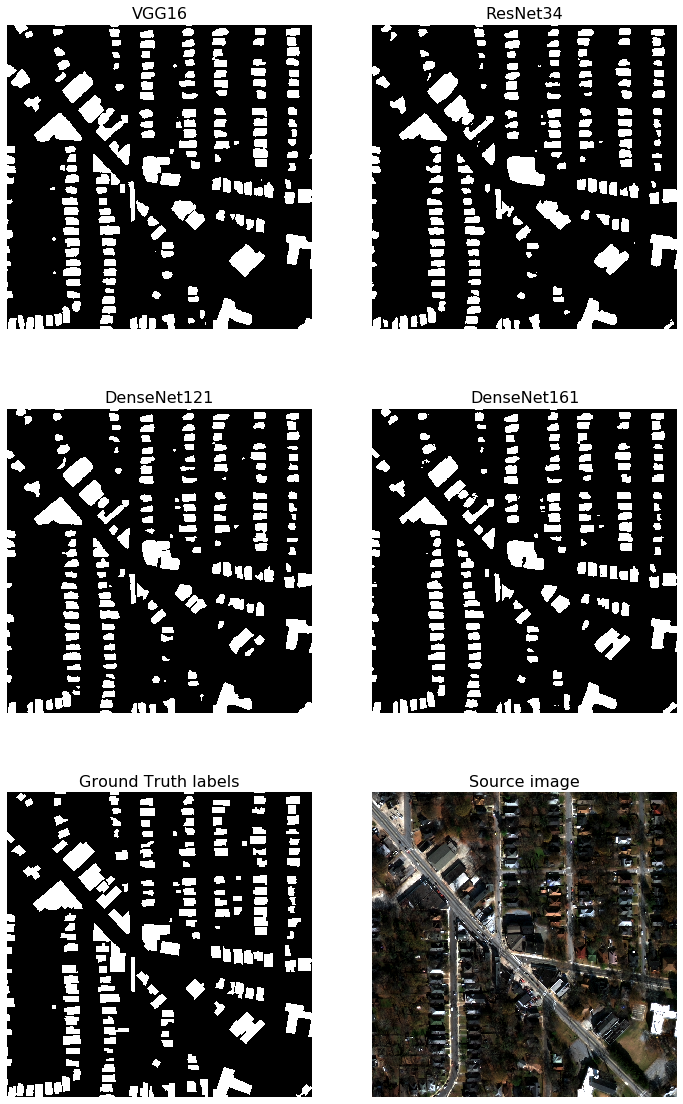

In [94]:
output_dirs = ['xdxd_inference_out', 'selimsef_resnet34_inference_out',
               'selimsef_densenet121_inference_out', 'selimsef_densenet161_inference_out']
model_names = ['VGG16', 'ResNet34', 'DenseNet121', 'DenseNet161']

f, axarr = plt.subplots(3, 2, figsize=(12, 20))

for i in range(4):
    im = skimage.io.imread(os.path.join(output_dirs[i], 'MVOI_nadir10_test_sample.tif'))
    im = (im > 0).astype('uint8')[:, :, 0]
    axarr[i//2, i%2].imshow(im, cmap='gray')
    axarr[i//2, i%2].set_title(model_names[i], size=16)
    axarr[i//2, i%2].axis('off')

ground_truth = sol.vector.mask.footprint_mask(
    os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.geojson'),
    reference_im = os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.tif'))

axarr[2, 0].imshow(ground_truth, cmap='gray')
axarr[2, 0].set_title('Ground Truth labels', size=16)
axarr[2, 0].axis('off')




# switch B and R for viz
im_arr = skimage.io.imread(os.path.join(data_path, 'MVOI_data/viz_version.tif'))
axarr[2, 1].imshow(im_arr[:, :, 0:3])
axarr[2, 1].set_title('Source image', size=16)
axarr[2, 1].axis('off')


As you can see, the models are _generally_ very similar in their predictions, but there are some subtle differences. Some of these may have dramatic effects on how their performance is scored!

## Pixel-wise metrics for prediction quality

We'll start by evaluating model performance with a couple of pixel-wise metrics, i.e., metrics that score models based on what fraction of the pixels are correct.

Let's start with "accuracy", since that's the most common term used when discussing model performance. Few people are actually familiar wtih the definition of accuracy:

$
\begin{align}
accuracy=\frac{TN+TP}{TN+TP+FN+FP}
\end{align}
$

Where:
- TN = True Negative (a pixel is ID'ed as non-building, and is in fact not a building)
- TP = True Positive (a pixel is ID'ed as building, and is in fact a building)
- FN = False Negative (a pixel is ID'ed as non-building, when it is, in fact, building)
- FP = False Positive (a pixel is ID'ed as building, but it's actually background)

In layperson's terms, this metric is essentially what fraction of pixels are correct. Let's calculate that for each model above.

VGG16
U-Net accuracy: 0.9381617283950617
ResNet34
U-Net accuracy: 0.9349555555555555
DenseNet121
U-Net accuracy: 0.9345234567901235
DenseNet161
U-Net accuracy: 0.9365938271604938


(0.85, 1)

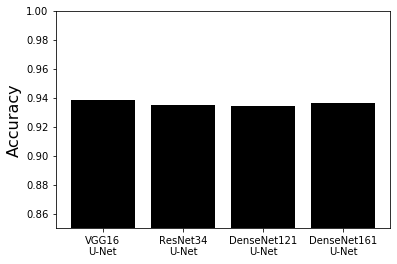

In [100]:
def acc(prediction, ground_truth):
    return np.sum(prediction == ground_truth)/float(prediction.size)

output_dirs = ['xdxd_inference_out', 'selimsef_resnet34_inference_out',
               'selimsef_densenet121_inference_out', 'selimsef_densenet161_inference_out']
model_names = ['VGG16\nU-Net', 'ResNet34\nU-Net', 'DenseNet121\nU-Net', 'DenseNet161\nU-Net']

ground_truth = ground_truth > 0

accuracy_scores = []

for i in range(4):
    pred_image = skimage.io.imread(os.path.join(output_dirs[i], 'MVOI_nadir10_test_sample.tif'))
    pred_image = pred_image > 0
    pred_image = pred_image[:, :, 0]
    accuracy = acc(pred_image, ground_truth)
    print("{} accuracy: {}".format(model_names[i], accuracy))
    accuracy_scores.append(accuracy)

plt.bar(model_names, accuracy_scores, color='black')
plt.ylabel('Accuracy', size=16)
plt.ylim((0.85, 1))

These scores are _very_ similar - tiny fractions of a percent different - and more or less impossible to detect, even zoomed way in on the graph. What if we try a different metric, like $F_1$ score:

$
\begin{align}
F_1 = 2*\frac{P*R}{P+R}
\end{align}
$

Where
- P = Precision:

$
\begin{align}
\frac{TP}{TP+FP}
\end{align}
$
- R = Recall:

$
\begin{align}
\frac{TP}{TP+FN}
\end{align}
$

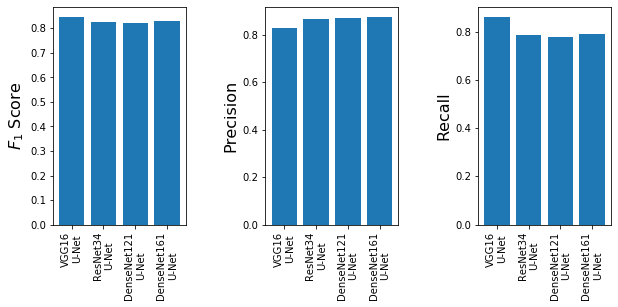

In [105]:
f1_scores = []
precision = []
recall = []
for i in range(4):
    pred_image = skimage.io.imread(os.path.join(output_dirs[i], 'MVOI_nadir10_test_sample.tif'))
    pred_image = pred_image > 0
    pred_image = pred_image[:, :, 0]
    results = sol.eval.pixel.f1(ground_truth, pred_image)
#    print("{} F1: {}".format(model_names[i], results[0]))
#    print("{} Precision: {}".format(model_names[i], results[1]))
#    print("{} Recall: {}".format(model_names[i], results[2]))
    f1_scores.append(results[0])
    precision.append(results[1])
    recall.append(results[2])

f, axarr = plt.subplots(1, 3, figsize=(10, 4))
f.subplots_adjust(wspace=0.6)
axarr[0].bar(model_names, f1_scores)
axarr[0].set_xticklabels(labels=model_names, rotation=90)
axarr[0].set_ylabel('$F_1$ Score', size=16)
axarr[1].bar(model_names, precision)
axarr[1].set_xticklabels(labels=model_names, rotation=90)
axarr[1].set_ylabel('Precision', size=16)
axarr[2].bar(model_names, recall)
axarr[2].set_xticklabels(labels=model_names, rotation=90)
axarr[2].set_ylabel('Recall', size=16);


This shows _some_ pixel-wise difference between these different predictions - specifically, the VGG16 model provides _slightly_ better prediction quality on a pixel-by-pixel basis. The Precision and Recall plots shed a bit more light.

This still leaves potential for problems, though. The two examples below produce the exact same $F_1$ score, Precision, and Recall on a pixel-wise basis:

<img src='files/f1_pixelwise_prec_rec_example.png' style='width:800px'>

Depending on your use case, you may want to be able to distinguish between these two sets of predictions and optimize for one rather than the other. To do so, we'll need something more than pixel-wise metrics.

## Object-wise metrics for prediction quality
At CosmiQ Works, we generally use object-wise metrics to evaluate model performance for building footprint extraction tasks (or other object identification tasks).
This involves a two-step process, adapted from the [ImageNet](www.image-net.org) competitions:

1. Call positive and negative building identifications using an Intersection-over-Union (IoU) threshold
2. Calculate the $F_1$ score of identifications at an object level (rather than a pixel level)

The graphic below displays how we calculate IoU for a prediction.

<img src="files/iou_schematic.png" style="width: 800px">

`solaris` provides functionality to do this calculation for all of the objects within a given set of vector labels, providing both the object-by-object IoU scores.

Next, we set a threshold for how high a prediction's IoU must be with a ground truth object to be called "successful" (i.e. a True Positive). We generally set this threshold at __0.5__ for the SpaceNet Challenges. This allows us to identify specific predictions as True Positives and False Positives, as well as identify False Negatives where there wasn't a high-quality prediction. We call this metric the __SpaceNet Metric__.

Using that threshold, let's assess the SpaceNet Metric for the four prediction sets we generated earlier:

169it [00:02, 63.47it/s]
163it [00:02, 65.66it/s]
168it [00:02, 72.15it/s]
165it [00:02, 70.03it/s]


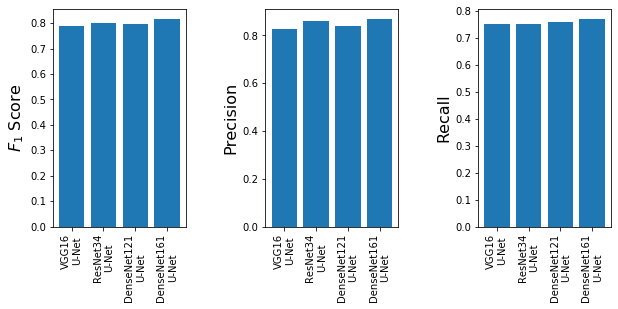

In [111]:
evaluator = sol.eval.base.Evaluator(os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.geojson'))
prediction_dirs = ['xdxd_inference_out', 'selimsef_resnet34_inference_out',
               'selimsef_densenet121_inference_out', 'selimsef_densenet161_inference_out']
model_names = ['VGG16\nU-Net', 'ResNet34\nU-Net', 'DenseNet121\nU-Net', 'DenseNet161\nU-Net']

f1_scores = []
precision = []
recall = []
for i in range(4):
    evaluator.load_proposal(os.path.join(prediction_dirs[i],'MVOI_nadir10_predictions.geojson'),
                            pred_row_geo_value='geometry',
                            conf_field_list=[])
    results = evaluator.eval_iou(miniou=0.5, calculate_class_scores=False)
    f1_scores.append(results[0]['F1Score'])
    precision.append(results[0]['Precision'])
    recall.append(results[0]['Recall'])

f, axarr = plt.subplots(1, 3, figsize=(10, 4))
f.subplots_adjust(wspace=0.6)
axarr[0].bar(model_names, f1_scores)
axarr[0].set_xticklabels(labels=model_names, rotation=90)
axarr[0].set_ylabel('$F_1$ Score', size=16)
axarr[1].bar(model_names, precision)
axarr[1].set_xticklabels(labels=model_names, rotation=90)
axarr[1].set_ylabel('Precision', size=16)
axarr[2].bar(model_names, recall)
axarr[2].set_xticklabels(labels=model_names, rotation=90)
axarr[2].set_ylabel('Recall', size=16);


These are still close. What if we increase the IoU threshold to 0.85, meaning predictions must be much more similar to the ground truth to be deemed "correct"?

169it [00:02, 63.03it/s]
163it [00:02, 63.22it/s]
168it [00:02, 63.00it/s]
165it [00:02, 68.56it/s]


Text(0, 0.5, 'Recall')

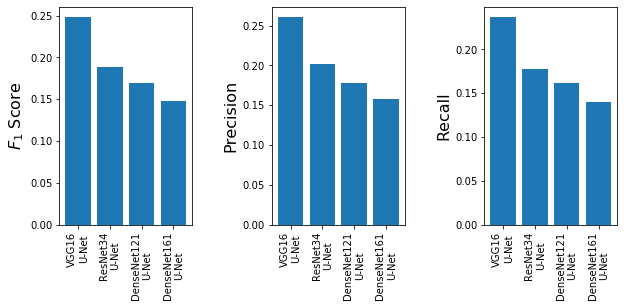

In [112]:
f1_scores = []
precision = []
recall = []
for i in range(4):
    evaluator.load_proposal(os.path.join(prediction_dirs[i],'MVOI_nadir10_predictions.geojson'),
                            pred_row_geo_value='geometry',
                            conf_field_list=[])
    results = evaluator.eval_iou(miniou=0.85, calculate_class_scores=False)
    f1_scores.append(results[0]['F1Score'])
    precision.append(results[0]['Precision'])
    recall.append(results[0]['Recall'])

f, axarr = plt.subplots(1, 3, figsize=(10, 4))
f.subplots_adjust(wspace=0.6)
axarr[0].bar(model_names, f1_scores)
axarr[0].set_xticklabels(labels=model_names, rotation=90)
axarr[0].set_ylabel('$F_1$ Score', size=16)
axarr[1].bar(model_names, precision)
axarr[1].set_xticklabels(labels=model_names, rotation=90)
axarr[1].set_ylabel('Precision', size=16)
axarr[2].bar(model_names, recall)
axarr[2].set_xticklabels(labels=model_names, rotation=90)
axarr[2].set_ylabel('Recall', size=16)

It's notable that 1. all of the scores drop substantially, but 2. the VGG16 model really jumps out as better than the others when the threshold is increased!